In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('/content/dirA.125910-packets.csv')

In [3]:
data.head()

,Timestamp,Source,Destination,Protocol,Length
0,2019-01-17 18:29:10.467105,26.120.99.176,175.84.134.113,TCP,1504.0
1,2019-01-17 18:29:10.467106,181.47.185.47,30.241.116.225,TCP,56.0
2,2019-01-17 18:29:10.467106,169.85.223.179,136.127.65.205,TCP,1484.0
3,2019-01-17 18:29:10.467107,169.85.223.179,136.127.65.205,TCP,1484.0
4,2019-01-17 18:29:10.467108,42.27.128.236,180.211.115.195,_WS.SHORT,1470.0


In [4]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')

In [5]:
data.dtypes

,0
Timestamp,datetime64[ns]
Source,object
Destination,object
Protocol,object
Length,float64


In [6]:
invalid_rows = data[data['Timestamp'].isna()]
print(f"Rows with invalid timestamps:\n{invalid_rows}")

Rows with invalid timestamps:
       Timestamp Source Destination Protocol  Length
157745       NaT    NaN         NaN      NaN     NaN


In [7]:
data.dropna(subset=['Timestamp'], inplace=True)

In [8]:
data.drop_duplicates(inplace=True)

In [9]:
# basic stats

In [10]:
print("Basic Statistics on Packet Lengths:")
print(data['Length'].describe())

Basic Statistics on Packet Lengths:
count    156819.000000
mean        919.649054
std         655.339249
min          50.000000
25%          93.000000
50%        1408.000000
75%        1496.000000
max        1504.000000
Name: Length, dtype: float64


In [11]:
protocol_counts = data['Protocol'].value_counts()
print("Protocol Distribution:")
print(protocol_counts)

Protocol Distribution:
Protocol
TCP          124884
_WS.SHORT     29868
ICMP           1240
ESP             790
IP               37
Name: count, dtype: int64


In [12]:
data['Hour'] = data['Timestamp'].dt.hour
packets_per_hour = data.groupby('Hour').size()
print("Packets per Hour:")
print(packets_per_hour)

Packets per Hour:
Hour
18    156819
dtype: int64


In [13]:
# visualizations

In [14]:
import matplotlib.pyplot as plt

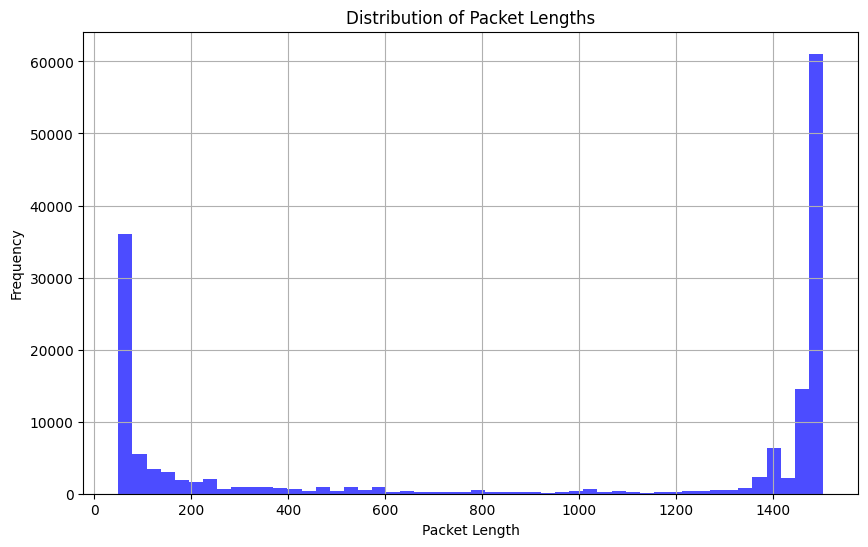

In [15]:
plt.figure(figsize=(10, 6))
plt.hist(data['Length'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Packet Lengths')
plt.xlabel('Packet Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

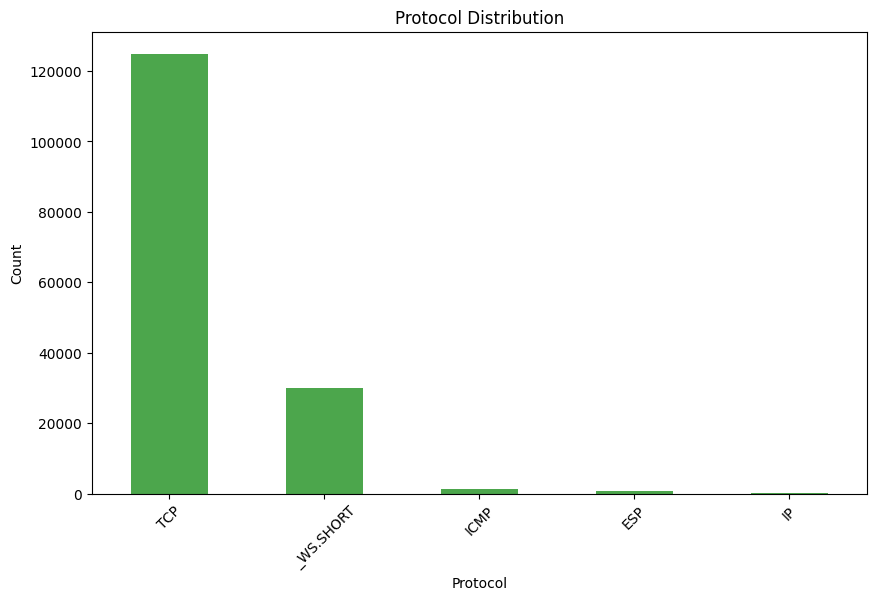

In [16]:
plt.figure(figsize=(10, 6))
protocol_counts.plot(kind='bar', color='green', alpha=0.7)
plt.title('Protocol Distribution')
plt.xlabel('Protocol')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

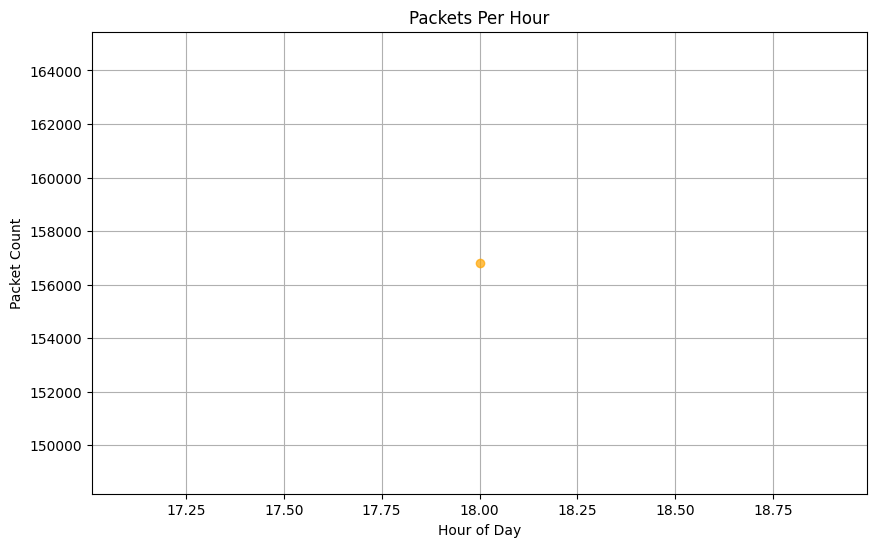

In [17]:
plt.figure(figsize=(10, 6))
packets_per_hour.plot(kind='line', marker='o', color='orange', alpha=0.7)
plt.title('Packets Per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Packet Count')
plt.grid(True)
plt.show()

In [18]:
# i make graf

In [19]:
import networkx as nx

In [20]:
G = nx.Graph()

for index, row in data.iterrows():
    source = row['Source']
    destination = row['Destination']
    length = row['Length']

    if G.has_edge(source, destination):
        G[source][destination]['weight'] += length
    else:
        G.add_edge(source, destination, weight=length)

In [21]:
print(f"Number of nodes: {len(G.nodes)}")
print(f"Number of edges: {len(G.edges)}")

Number of nodes: 34323
Number of edges: 28400


In [37]:
sample_size = len(G.nodes)//3
nodes = list(G.nodes())
sampled_nodes = nodes[:sample_size]
print(f'Sample size: {sample_size}')

Sample size: 11441


In [38]:
subgraph = G.subgraph(sampled_nodes)

In [39]:
pos = nx.spring_layout(subgraph, seed=42, k=0.15)

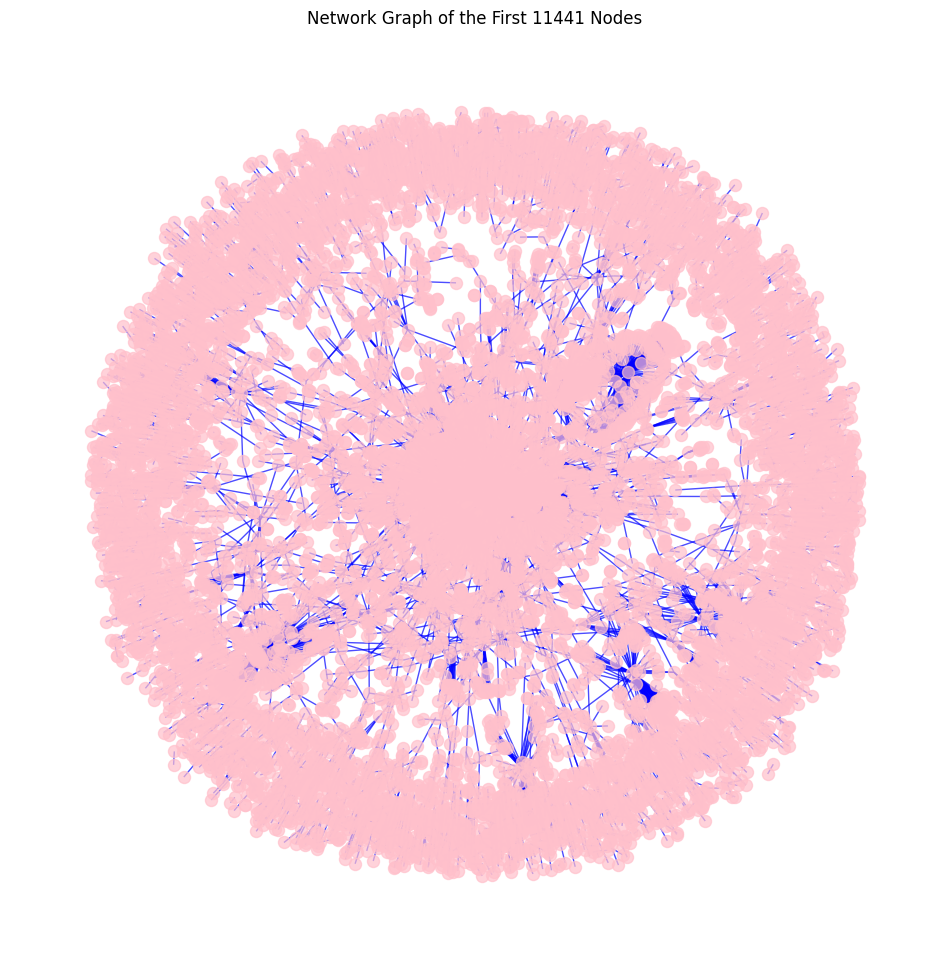

In [40]:
'''plt.figure(figsize=(12, 12))
nx.draw_networkx(G, node_size=50, font_size=10, with_labels=False, alpha=0.7)
plt.title('Network Graph of Source and Destination IPs')
plt.show()'''

plt.figure(figsize=(12, 12))
nx.draw_networkx_edges(subgraph, pos, width=1.0, alpha=0.7, edge_color='blue')
nx.draw_networkx_nodes(subgraph, pos, node_size=75, node_color='pink', alpha=0.7)
plt.title(f'Network Graph of the First {sample_size} Nodes')
plt.axis('off')
plt.show()

In [41]:
print(f"Number of nodes in sampled subgraph: {subgraph.number_of_nodes()}")
print(f"Number of edges in sampled subgraph: {subgraph.number_of_edges()}")

Number of nodes in sampled subgraph: 11441
Number of edges in sampled subgraph: 9779


In [42]:
# girvan newman community detection????

In [43]:
from networkx.algorithms.community import girvan_newman

In [ ]:
communities = girvan_newman(subgraph)
first_community = next(communities)  # Get the first level of communities
print(f"First level of communities: {first_community}")

In [ ]:
if not first_community:
    print("The first community is empty.")
else:
    print(f"Nodes in the first community: {first_community}")

In [ ]:
if isinstance(first_community, set):
    # If the community is a set of sets, flatten it
    flattened_community = []
    for community in first_community:
        if isinstance(community, set):
            flattened_community.extend(list(community))  # Add nodes from the set
        else:
            flattened_community.append(community)  # If it's a single node, add it
else:
    # If the community is already a flat list, use it directly
    flattened_community = list(first_community)
print(f"Flattened community nodes: {flattened_community}")

In [55]:
valid_nodes = set(G.nodes())  # Get all valid nodes in the graph
flattened_community = [node for node in flattened_community if node in valid_nodes]

In [ ]:
if not flattened_community:
    print("No valid nodes in the community.")
else:
    print(f"Valid community nodes: {flattened_community}")

G_community = subgraph.subgraph(flattened_community)

In [57]:
if G_community.number_of_nodes() == 0 or G_community.number_of_edges() == 0:
    print("The community subgraph is empty. No nodes or edges to display.")
else:
    print(f"Number of nodes in community subgraph: {G_community.number_of_nodes()}")
    print(f"Number of edges in community subgraph: {G_community.number_of_edges()}")

    # Step 9: Visualize the community network
    pos = nx.spring_layout(G_community, seed=42, k=0.15)  # Layout for node positions

    plt.figure(figsize=(10, 10))
    nx.draw_networkx_edges(G_community, pos, width=1.0, alpha=0.7, edge_color='blue')
    nx.draw_networkx_nodes(G_community, pos, node_size=300, node_color='pink', alpha=0.7)
    plt.title(f'Community Graph of the First {sample_size} Sampled Nodes')
    plt.axis('off')
    plt.show()

    # Print the number of nodes and edges in the community subgraph
    print(f"Number of nodes in sampled community subgraph: {G_community.number_of_nodes()}")
    print(f"Number of edges in sampled community subgraph: {G_community.number_of_edges()}")

In [ ]:
# lemme look more into this

In [ ]:
source_traffic = data.groupby('Source')['Length'].sum()

# top 5 sources with the highest traffic volume
top_sources = source_traffic.nlargest(5)
print(f"Top 5 sources by traffic volume:\n{top_sources}")

In [ ]:
# bursts of traffic??

In [ ]:
data.set_index('Timestamp', inplace=True)
resampled_data = data.resample('T').size()  # Resample by minute

plt.figure(figsize=(10, 6))
resampled_data.plot(kind='line', color='blue', alpha=0.7)
plt.title('Packet Arrival Pattern Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Packets')
plt.grid(True)
plt.show()
